In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset, Subset

import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [3]:
# directory setup cell
repo = 'tree-finder/'
location = 'local'
save_mode = True

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
  root = local_root
elif location == 'google':
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  root = colab_root
elif location == 'aws':
  root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
results_path = repo_path + 'results/'
sys.path.append(repo_path)

In [4]:
# setup cell
from notebooks.viz_fns import show_image_batch, set_plt_settings, create_class_vis
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetTransferClassifier, ConvnextTransferClassifier, TransformerTransferClassifier

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [5]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=[10,25,50])
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [6]:
# load image scores
filename = 'images_spec_realtree_pcts.csv'
realtree_likelihood = np.loadtxt(data_path + filename).astype(float).tolist()

# subset based on threshold
threshold=0.85
flag = np.array(realtree_likelihood) > threshold
realtree_idxs = (np.arange(0, len(flag))[flag]).tolist()
print(f'\nimages meeting threshold ({threshold}): {sum(flag)} ({sum(flag)/len(flag):0.2%})')
# realtree_idxs = None

# make dataloaders with the subset data
dataloaders, ds_sizes = make_dataloaders(
    dataset=treeds, subset=realtree_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=32, seed=1)


images meeting threshold (0.85): 24944 (75.97%)
dataloader sizes: {'all': 24944, 'train': 16836, 'validate': 5613, 'test': 2495, 'sampler': 4}


# Load final model

In [7]:
# load final model and final model weights
final_model = ResnetTransferClassifier(num_classes=7, retrain_last_cnblock=True).to(device)
final_model_wts = torch.load(model_path + 'ResnetClassifierOneLayer.pt', map_location=torch.device('cpu'))
final_model.load_state_dict(final_model_wts)

<All keys matched successfully>

# Assess final model

In [8]:
# define small loader for testing
random_idxs = np.array(realtree_idxs)[np.random.choice(range(len(realtree_idxs)), 500)]
small_loaders, small_ds_sizes = make_dataloaders(
    dataset=treeds, subset=random_idxs, test_split=0.10, val_split=0.25, 
    sampleN=4, batch_size=10, seed=15)

# setup testing parameters
# loaders = small_loaders
# sizes = small_ds_sizes
loaders = dataloaders
sizes = ds_sizes

dataloader sizes: {'all': 500, 'train': 337, 'validate': 113, 'test': 50, 'sampler': 4}


In [9]:
# make predictions on test set for final model
images = torch.Tensor()
classes = torch.Tensor()
class_scores = torch.Tensor()

for X, y in tqdm(loaders['test']):
  X, y = X.to(device=device), y.to(device=device)
  out = final_model(X)
  images = torch.cat((images, X))
  classes = torch.cat((classes, y))
  class_scores = torch.cat((class_scores, out))

100%|██████████| 78/78 [28:28<00:00, 21.91s/it]


### Top1 and Top2 accuracy

In [10]:
# calculate top1 and top2 accuracy
N_test = sizes['test']
true_class = classes.int()
true_class_scores = class_scores[range(N_test), classes.numpy()]

max_classes = torch.argsort(class_scores, dim=-1, descending=True)
pred_class = max_classes[:, 0:1].squeeze(dim=-1)
pred_class_scores = class_scores[range(N_test), pred_class]

N_acc_1 = torch.sum((pred_class == classes)).item()
N_acc_2 = torch.sum((max_classes[:, 0:2] == classes.unsqueeze(dim=-1)).any(dim=-1)).item()
print('top-1 accuracy:', N_acc_1 / N_test)
print('top-2 accuracy:', N_acc_2 / N_test)

top-1 accuracy: 0.7991983967935872
top-2 accuracy: 0.9106212424849699


### Confusion matrix

In [11]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(true_class, pred_class, normalize='true')

df_cm = pd.DataFrame(cf_matrix, index = [i for i in class_names],
                     columns = [i for i in class_names]).round(2)
abbrevs = ['BL', 'BW', 'C', 'HL', 'LP', 'O', 'P']
df_cm.columns = abbrevs
df_cm.index = abbrevs
print(df_cm.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &    BL &    BW &     C &    HL &    LP &     O &     P \\
\midrule
BL &  0.77 &  0.06 &  0.03 &  0.10 &  0.02 &  0.02 &  0.02 \\
BW &  0.05 &  0.76 &  0.04 &  0.02 &  0.01 &  0.04 &  0.08 \\
C  &  0.03 &  0.03 &  0.83 &  0.02 &  0.01 &  0.03 &  0.05 \\
HL &  0.15 &  0.06 &  0.01 &  0.71 &  0.01 &  0.04 &  0.02 \\
LP &  0.01 &  0.02 &  0.01 &  0.00 &  0.94 &  0.01 &  0.01 \\
O  &  0.03 &  0.04 &  0.02 &  0.01 &  0.02 &  0.84 &  0.03 \\
P  &  0.02 &  0.10 &  0.06 &  0.02 &  0.02 &  0.05 &  0.73 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_5654/2277623921.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_cm.to_latex())


### Precision and recall

In [12]:
# precision and recall summary
from sklearn.metrics import classification_report
precall = classification_report(y_true=true_class, y_pred=pred_class, output_dict=True)
precall = pd.DataFrame(precall).T.round(3).drop(['accuracy', 'macro avg'])
precall.index = abbrevs + ['weighted avg']
print(precall.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  precision &  recall &  f1-score &  support \\
\midrule
BL           &      0.745 &   0.767 &     0.756 &    377.0 \\
BW           &      0.748 &   0.763 &     0.756 &    401.0 \\
C            &      0.847 &   0.834 &     0.841 &    398.0 \\
HL           &      0.766 &   0.708 &     0.736 &    301.0 \\
LP           &      0.913 &   0.941 &     0.927 &    357.0 \\
O            &      0.797 &   0.844 &     0.820 &    307.0 \\
P            &      0.773 &   0.732 &     0.752 &    354.0 \\
weighted avg &      0.799 &   0.799 &     0.799 &   2495.0 \\
\bottomrule
\end{tabular}



/var/folders/mw/dy3m3wg11js6x91fwng5ptdw0000gn/T/ipykernel_5654/3538973967.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(precall.to_latex())


### Top and bottom N images

image saved to file: /Users/etriesch/dev/tree-finder/results/fig_top_img.png


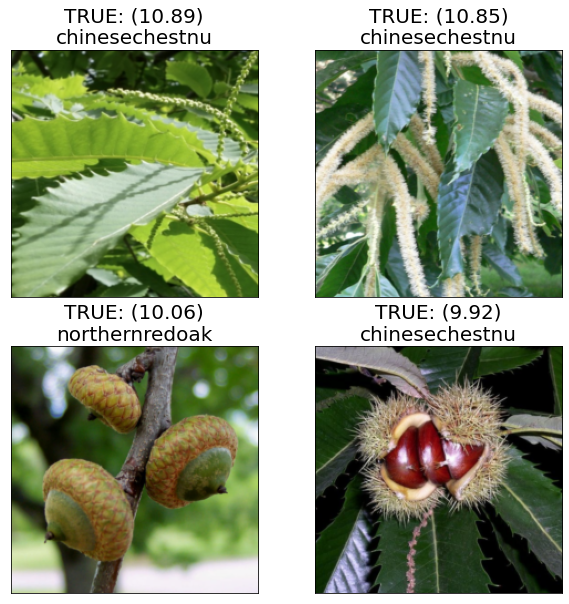

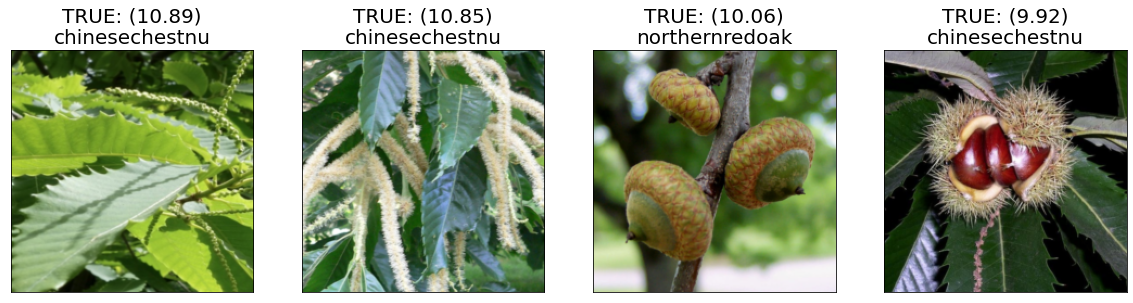

In [13]:
# print N top images
num_images = 4
# get highest scoring images
top_image_idxs = torch.argsort(true_class_scores, descending=True)[0:num_images]
top_true_class = true_class[top_image_idxs]
top_true_scores = true_class_scores[top_image_idxs]
top_images = images[top_image_idxs]

# for report
show_image_batch(top_images.cpu(), MEAN, STD, ncol=2,
title=[f'TRUE: ({l:0.2f})\n{class_names[x][:14]}' for x,l in zip(top_true_class, top_true_scores)],
figdim=10, savetofile=results_path + 'fig_top_img.png')

# for presentation
show_image_batch(top_images.cpu(), MEAN, STD, ncol=4,
title=[f'TRUE: ({l:0.2f})\n{class_names[x][:14]}' for x,l in zip(top_true_class, top_true_scores)],
figdim=20, savetofile=None)

image saved to file: /Users/etriesch/dev/tree-finder/results/fig_bott_img.png


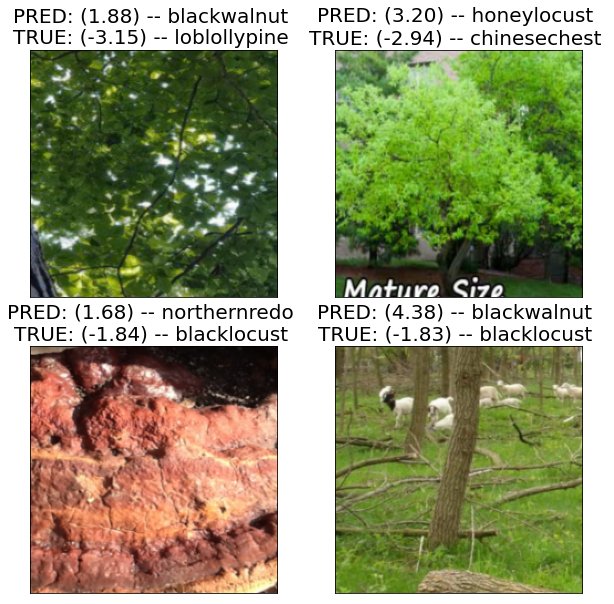

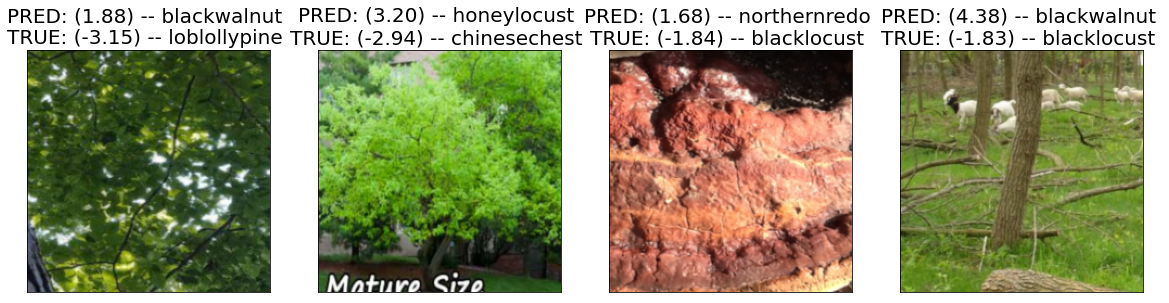

In [16]:
# print N bottom images
# get highest scoring images
bott_image_idxs = torch.argsort(true_class_scores, descending=False)[0:num_images]
bott_true_class = true_class[bott_image_idxs]
bott_true_scores = true_class_scores[bott_image_idxs]
bott_pred_class = pred_class[bott_image_idxs]
bott_pred_scores = pred_class_scores[bott_image_idxs]
bott_images = images[bott_image_idxs]

# for report
show_image_batch(
    bott_images.cpu(), MEAN, STD, ncol=2,
    title=[f'PRED: ({s_p:0.2f}) -- {class_names[x_p][:12]} \nTRUE: ({s_t:0.2f}) -- {class_names[x_t][:12]} ' 
           for x_t, s_t, x_p, s_p in zip(bott_true_class, bott_true_scores, bott_pred_class, bott_pred_scores)],
           figdim=10, savetofile=results_path + 'fig_bott_img.png'
    )

# for presentation
show_image_batch(
    bott_images.cpu(), MEAN, STD, ncol=4,
    title=[f'PRED: ({s_p:0.2f}) -- {class_names[x_p][:12]} \nTRUE: ({s_t:0.2f}) -- {class_names[x_t][:12]} ' 
           for x_t, s_t, x_p, s_p in zip(bott_true_class, bott_true_scores, bott_pred_class, bott_pred_scores)],
           figdim=20, savetofile=None
    )

### Visualize classes with gradient ascent

In [17]:
# load convnext model (i find it produces better visualizations)
m_convnextfc = ConvnextTransferClassifier(num_classes=7, retrain_last_cnblock=False).to(device)
convnextfc_wts = torch.load(model_path + 'ConvnextClassifierFC.pt', map_location=torch.device('cpu'))
m_convnextfc.load_state_dict(convnextfc_wts)


<All keys matched successfully>

In [19]:
# generate tensors for image visualizations for each class
dtype = torch.FloatTensor
class_vis = torch.Tensor()
for c in tqdm(range(len(class_names))):
  cv = create_class_vis(target_y=c, model=m_convnextfc, class_names=class_names, dtype=dtype, num_iterations=100)
  class_vis = torch.concat((class_vis, cv.unsqueeze(0)))

100%|██████████| 7/7 [03:43<00:00, 31.94s/it]


image saved to file: /Users/etriesch/dev/tree-finder/results/fig_class_vis.png


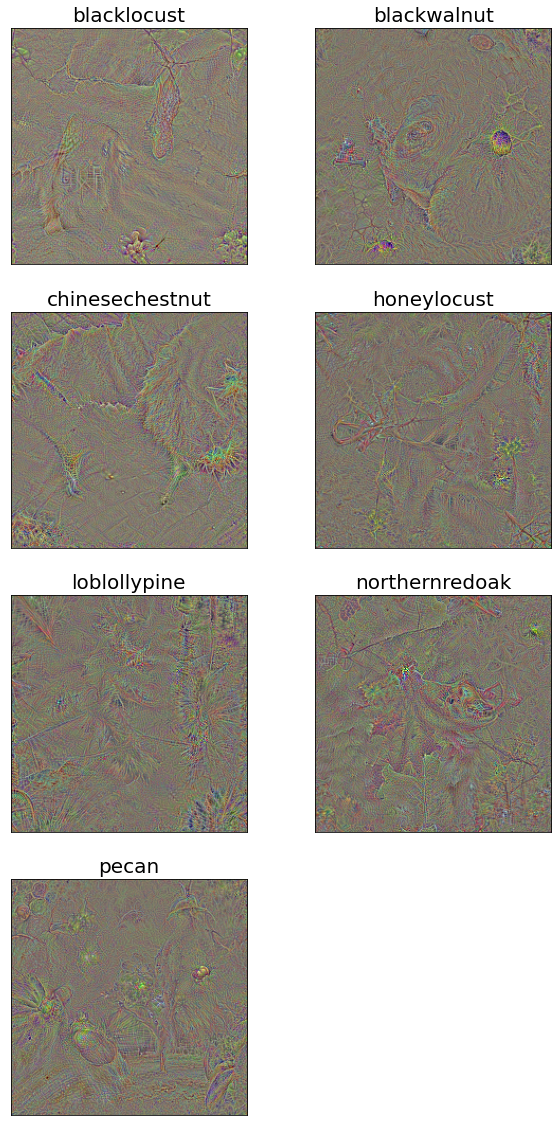

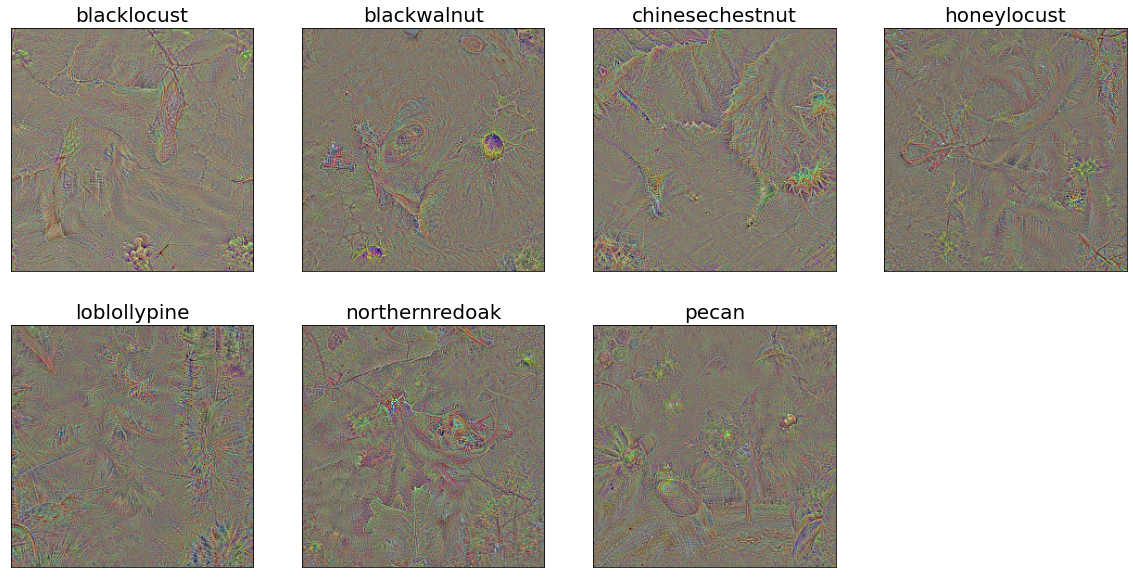

In [23]:
# for report
show_image_batch(class_vis.cpu(), title=[x for x in class_names], 
figdim=20, ncol=2, savetofile=results_path + 'fig_class_vis.png'
# figdim=20, ncol=2, savetofile=None
)

# for presentation
show_image_batch(class_vis.cpu(), title=[x for x in class_names], 
figdim=20, ncol=4, savetofile=None
)